In [1]:
import pandas as pd
import polyline


import matplotlib.pyplot as plt
import numpy as np
from numpy.linalg import norm

from sklearn.model_selection import train_test_split
#from sklearn.preprocessing import Imputer
from sklearn.impute import SimpleImputer 
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import StratifiedKFold
 
#Оптимизация буста    
import xgboost as xgb
from sklearn import preprocessing
# from sklearn.cross_validation import train_test_split
# from sklearn.cross_validation import *

from sklearn.model_selection import GridSearchCV
#from sklearn.grid_search import GridSearchCV




# 1. Предсказание поведения сервиса. Весьма умеренно зверская) задача


In [102]:
data = pd.read_csv('predict.csv')

data.columns

Index(['timestamp', 'count', 'conns', 'read_bytes_total', 'latency_ms_sum'], dtype='object')

# Поиск Аномалий, но Сперва! Standardize the Data

In [134]:
from sklearn.preprocessing import StandardScaler
features = ['timestamp', 'count', 'conns', 'read_bytes_total']
# Separating out the features
x = data.loc[:, features].values
# Separating out the target
y = data.loc[:,'latency_ms_sum'].values
# Standardizing the features
x = StandardScaler().fit_transform(x)

X =pd.DataFrame(x)
X.fillna(0,inplace=True, axis=1)
X.describe()

,0,1,2,3
count,8.352000e+03,8.352000e+03,8.352000e+03,8.352000e+03
mean,3.161052e-17,4.152835e-16,1.968147e-16,1.968280e-16
std,1.000060e+00,9.781470e-01,9.781470e-01,9.781470e-01
min,-1.731843e+00,-1.792109e+00,-3.822831e+00,-1.798848e+00
25%,-8.659217e-01,-6.622916e-01,-6.278116e-01,-6.447271e-01
50%,0.000000e+00,0.000000e+00,-1.106322e-01,-2.675270e-02
75%,8.659217e-01,7.795441e-01,4.640115e-01,6.306004e-01
max,1.731843e+00,1.752219e+00,4.854290e+00,2.030682e+00


# PCA Projection to 2D

In [135]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)


In [159]:
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])
principalDf.head()

,principal component 1,principal component 2
0,0.776591,-1.686521
1,0.765655,-1.742252
2,0.762976,-1.754786
3,0.760301,-1.767321
4,0.744663,-1.849008


# Видим, что аномалии присутсвуют

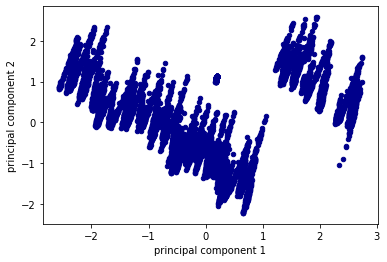

In [164]:
principalDf.plot.scatter(x='principal component 1',
                      y='principal component 2',
                      c='DarkBlue')
#finalDf = pd.concat([principalDf, data[['latency_ms_sum']]], axis = 1)

# А Давайте попробуем XGBoost?!?!?!?!?

In [17]:
data.dropna(axis=0, subset=['latency_ms_sum'], inplace=True)

y = data.latency_ms_sum
X = data.drop(['latency_ms_sum'], axis=1).select_dtypes(exclude=['object'])

train_X, test_X, train_y, test_y = train_test_split(X.values, y.values, test_size=0.25)

my_imputer = SimpleImputer()

train_X = my_imputer.fit_transform(train_X)
test_X = my_imputer.transform(test_X)




my_model = XGBRegressor(n_estimators=1100, learning_rate=0.05)
my_model.fit(train_X, train_y, early_stopping_rounds=5, 
             eval_set=[(test_X, test_y)], verbose=False)

XGBRegressor(base_score=0.5, booster=None, colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints=None,
             learning_rate=0.05, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             n_estimators=1100, n_jobs=0, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
             validate_parameters=False, verbosity=None)

In [18]:
predictions1 = my_model.predict(test_X)
#predictions1

In [19]:
err = abs(test_y-predictions1).mean()

In [20]:
print("ES and LR Mean Absolute Error : " + str(mean_absolute_error(predictions1, test_y)))

ES and LR Mean Absolute Error : 466834.42320996016


# ES and LR Mean Absolute Error : 18138.6426156 

In [21]:
len(predictions1)

1998

In [22]:
# Для наглядности построим график результатов для первых 100 из 2000 точек

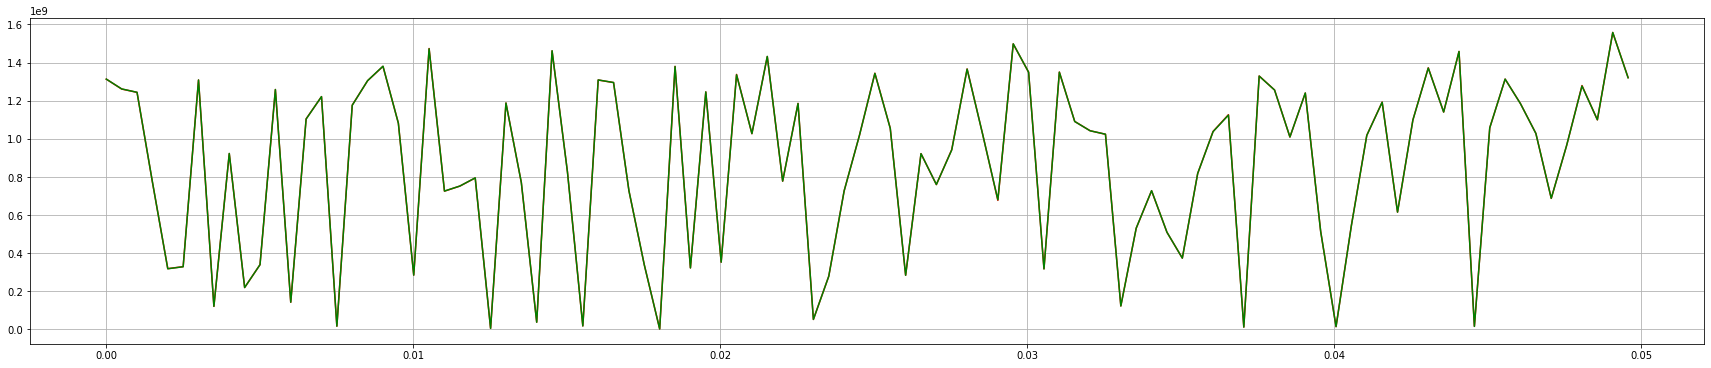

In [96]:
x = np.linspace(0, 1, 1998)[:100]

y1 = predictions1[:100]
y2 = test_y[:100]
plt.figure(figsize=(30,6))
plt.grid()            
plt.plot(x, y1, label='Предсказанное', color='red')
plt.plot(x, y2, label='Реальное', color='green')

# 2.       Оценка среднего значения и дисперсии для времени обработки запросов сервисом. Не зверская) задача


In [11]:
# timestamp - календарное время снятия показаний работы сервиса в формате time_t.
# Inf - Суммарное количество обработанных запросов сервисом с момента старта.
# 1 - Суммарное количество обработанных запросов, каждый из которых занял меньше чем 1 миллисекунду.
# 2 - Суммарное количество обработанных запросов, каждый из которых занял меньше чем 2 миллисекунды.
# ...
# 90000 - Суммарное количество обработанных запросов, каждый из которых занял меньше чем 90 секунд.
 
# Ваша задача:
# 1.       Рассчитать среднее значение и дисперсию для времени обработки запросов сервисом в зависимости от календарного времени.
# 2.       Отобразить среднее значение времени обработки запроса и дисперсию на графиках в зависимости от календарного времени.

In [12]:
f = pd.read_csv('ms_bucket.csv')
f.head(1)

,timestamp,Inf,1,10,100,1000,10000,100000,110000,120000,...,40000,5,50,500,5000,50000,60000,70000,80000,90000
0,1564650000,88967916.0,56905292.0,72624894.0,88366166.0,88967203.0,88967824.0,88967916.0,88967916.0,88967916.0,...,88967916.0,69234222.0,87376013.0,88962228.0,88967673.0,88967916.0,88967916.0,88967916.0,88967916.0,88967916.0


In [13]:
f_time=f[['timestamp','Inf']]
f=f[f.columns[2:]]

#считаем сколько времени занял каждый вид запроса (время запроса * колличество таких запросов)

for time in f.columns:
    f[time]*=int(time)

In [14]:
#df[['B','C']].div(df.A, axis=0)

f_time['sum']=f.sum(axis=1)
f_time['std']=f.std(axis=1)

In [15]:
f_time['sum'].div(f_time['Inf'],axis=0)    #делим  подсчитанну сумму на колличество
f_time['std'].div(f_time['Inf'],axis=0) 
f_time.head()

,timestamp,Inf,sum,std
0,1564650000,88967916.0,7.087663e+13,3.398051e+12
1,1564650300,88989154.0,7.089355e+13,3.398862e+12
2,1564650600,89004769.0,7.090599e+13,3.399459e+12
3,1564650900,89020289.0,7.091835e+13,3.400052e+12
4,1564651200,89026526.0,7.092332e+13,3.400290e+12


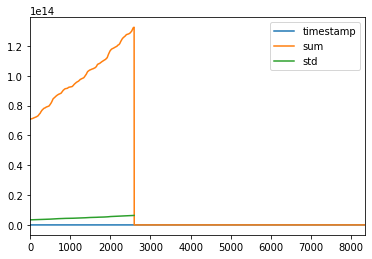

In [16]:
f_time.drop('Inf', inplace=True, axis=1)
f_time.plot()

# 3.       Классификация вредоносного поведения. Не зверская) задача


In [169]:
b = pd.read_csv('behavior.csv')
b.head()

,Unnamed: 0,hkey_local_machine\\software\microsoft\windows\currentversion\uninstall\mobileoptionpack,hkey_classes_root\\clsid\{148bd52a-a2ab-11ce-b11f-00aa00530503},hkey_current_user\\software\microsoft\windows\currentversion\urlmon settings,hkey_local_machine\\system\currentcontrolset\services\tcpip\parameters\interfaces\ms tcp loopback interface,hkey_local_machine\\software\microsoft\net framework setup\ndp\v3.5,hkey_local_machine\\software\microsoft\windows nt\currentversion\winlogon,hkey_local_machine\\software\microsoft\windows\currentversion\internet settings\user agent,hkey_local_machine\\system\currentcontrolset\services\dnscache\parameters,hkey_current_user\\software\microsoft\windows\currentversion\explorer\mountpoints2\cpc\volume,...,c:\windows\system32\kernel32.dll,c:\documents and settings\username\application data\microsoft\cryptneturlcache\metadata\2bf68f4714092295550497dd56f57004,c:\windows\system32\shdocvw.dll,c:\windows\system32\psapi.dll,c:\windows\system32\cmd.exe,c:\windows\dll\mscorlib.pdb,\\.\vboxguest,unnamedfile,wdmaud.drv_file,tag
0,00005122106941E2A0B5A651249D71ADD11C561167F3F9...,0,0,0,0,0,2,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,0000CF95A98B33F00F4CDCBD13017EAB7B9589BE79617D...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,00015A2AEE06230C7E12B8D1E79F345F90008F0DD3175B...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,0001D0A0243A15D78F10DB87FD721E4F06F3B9892257FC...,0,0,0,0,0,4,0,0,0,...,1,0,0,0,0,0,0,0,0,0
4,0001D6A56EBCF3C0DEF053DA01454BF23021DE7DF1FC48...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [ ]:
X[‘tod’] = X.index.hour
# drop_first = True removes multi-collinearity
add_var = pd.get_dummies(X[‘tod’], prefix=’tod’, drop_first=True)
# Add all the columns to the model data
X = X.join(add_var)
# Drop the original column that was expanded
X.drop(columns=[‘tod’], inplace=True)
print(X.head())

In [ ]:
model = LinearRegression()
scores = []
kfold = KFold(n_splits=3, shuffle=True, random_state=42)
for i, (train, test) in enumerate(kfold.split(X, y)):
 model.fit(X.iloc[train,:], y.iloc[train,:])
 scores.append(model.score(X.iloc[test,:], y.iloc[test,:]))
print(scores)
